In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Try to import XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print('XGBoost is available')
except ImportError:
    XGBOOST_AVAILABLE = False
    print('XGBoost not installed. Will skip XGBoost model.')
    print('To install: pip install xgboost')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print('Libraries imported successfully')

XGBoost is available
Libraries imported successfully


## 1. Load Data and Prepare Train/Test Split

Load features and create the same train/test split as previous notebooks.

In [17]:
# Load features
PROCESSED = os.path.abspath(os.path.join('..', 'data', 'processed'))

# You can use either the original features or PCA-reduced features
USE_PCA_FEATURES = False  # Set to True to use PCA features

if USE_PCA_FEATURES:
    features_path = os.path.join(PROCESSED, 'features_pca.csv')
    print('Using PCA-reduced features')
else:
    features_path = os.path.join(PROCESSED, 'features.csv')
    print('Using original engineered features')

if not os.path.exists(features_path):
    print(f'ERROR: {features_path} not found')
else:
    df = pd.read_csv(features_path)
    print(f'Features loaded successfully')
    print(f'Dataset shape: {df.shape}')

Using original engineered features
Features loaded successfully
Dataset shape: (59238, 84)


In [18]:
# Identify target column
target_col = "Is_laundering"

print(f'Target column: {target_col}')
print(f'\nClass distribution:')
print(df[target_col].value_counts())

Target column: Is_laundering

Class distribution:
Is_laundering
0    49365
1     9873
Name: count, dtype: int64


In [19]:
# Define features and target
exclude_cols = [target_col, 'id', 'transaction_id', 'account_id', 'customer_id', 'Laundering_type']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target_col]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (59238, 83)
Target shape: (59238,)


In [20]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Training set: 47390 samples
Test set: 11848 samples


In [21]:
# Drop timestamp column if it exists (cannot be used directly in models)
if 'timestamp' in X_train.columns:
    print('Removing timestamp column from training and test sets...')
    X_train = X_train.drop('timestamp', axis=1)
    X_test = X_test.drop('timestamp', axis=1)
    print(f'Training set shape after dropping timestamp: {X_train.shape}')
    print(f'Test set shape after dropping timestamp: {X_test.shape}')
else:
    print('No timestamp column found - proceeding with training')

# Get updated feature columns list after dropping timestamp
feature_cols = X_train.columns.tolist()
print(f'\nFinal feature count: {len(feature_cols)}')

Removing timestamp column from training and test sets...
Training set shape after dropping timestamp: (47390, 82)
Test set shape after dropping timestamp: (11848, 82)

Final feature count: 82


## 2. Random Forest Model

Random Forest is an ensemble of decision trees that reduces overfitting and improves accuracy. Using memory-optimized parameters and subsampling for large datasets.

In [22]:
# Train Random Forest with memory-efficient parameters
print('Training Random Forest (memory-optimized)...')
rf_model = RandomForestClassifier(
    n_estimators=50,  # Reduced from 100 to save memory
    max_depth=10,     # Reduced from 15 to save memory
    random_state=42,
    class_weight='balanced',
    n_jobs=1,         # Use single thread to avoid memory overhead
    max_samples=0.8   # Use only 80% of samples for each tree
)
rf_model.fit(X_train, y_train)
print('Training complete.')

Training Random Forest (memory-optimized)...
Training complete.
Training complete.


In [23]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

print('=' * 60)
print('RANDOM FOREST - EVALUATION METRICS')
print('=' * 60)
print(f'Accuracy:  {rf_accuracy:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall:    {rf_recall:.4f}')
print(f'F1 Score:  {rf_f1:.4f}')
print(f'ROC-AUC:   {rf_roc_auc:.4f}')
print('=' * 60)

RANDOM FOREST - EVALUATION METRICS
Accuracy:  0.9240
Precision: 0.7402
Recall:    0.8380
F1 Score:  0.7860
ROC-AUC:   0.9560


In [24]:
# Classification report
print('\nDetailed Classification Report:')
print(classification_report(y_test, y_pred_rf))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      9873
           1       0.74      0.84      0.79      1975

    accuracy                           0.92     11848
   macro avg       0.85      0.89      0.87     11848
weighted avg       0.93      0.92      0.93     11848



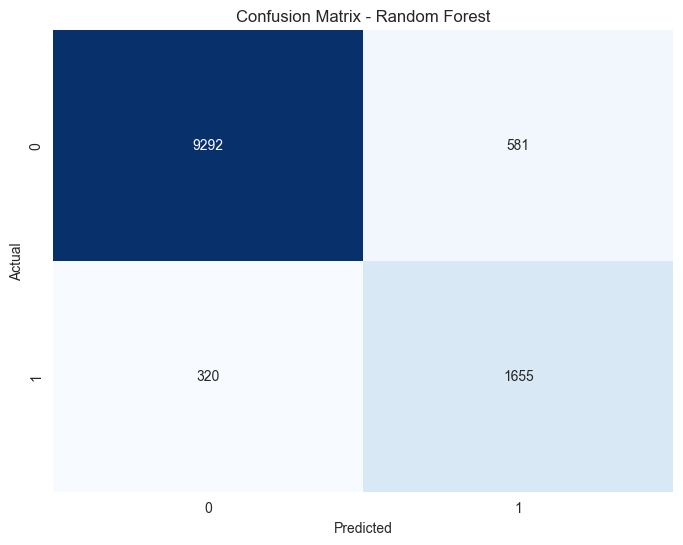


Confusion Matrix:
True Negatives:  9292
False Positives: 581
False Negatives: 320
True Positives:  1655


In [25]:
# Confusion Matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f'\nConfusion Matrix:')
print(f'True Negatives:  {rf_cm[0, 0]}')
print(f'False Positives: {rf_cm[0, 1]}')
print(f'False Negatives: {rf_cm[1, 0]}')
print(f'True Positives:  {rf_cm[1, 1]}')


Top 10 Most Important Features:
                    Feature  Importance
        number_transactions    0.253354
               num_incoming    0.239785
             total_incoming    0.134441
               num_outgoing    0.114295
             total_outgoing    0.055360
                 log_amount    0.033339
Received_currency_UK pounds    0.029651
                     Amount    0.024524
  Receiver_bank_location_UK    0.019872
  Payment_type_Cross-border    0.018751


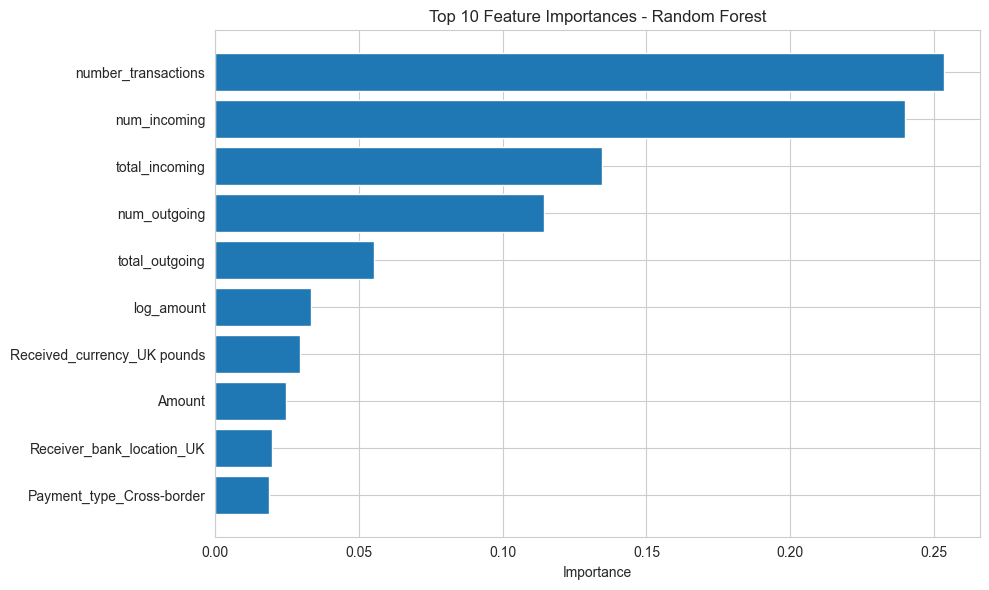

In [26]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print('\nTop 10 Most Important Features:')
print(feature_importance.head(10).to_string(index=False))

# Plot top features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3. XGBoost Model

XGBoost is a powerful gradient boosting algorithm. We'll train it if available.

In [27]:
if XGBOOST_AVAILABLE:
    # Calculate scale_pos_weight for class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    print(f'Scale pos weight: {scale_pos_weight:.2f}')
    
    # Train XGBoost
    print('\nTraining XGBoost...')
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    print('Training complete.')
else:
    print('XGBoost is not available. Skipping this model.')

Scale pos weight: 5.00

Training XGBoost...
Training complete.
Training complete.


In [28]:
if XGBOOST_AVAILABLE:
    # Make predictions
    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
    xgb_precision = precision_score(y_test, y_pred_xgb)
    xgb_recall = recall_score(y_test, y_pred_xgb)
    xgb_f1 = f1_score(y_test, y_pred_xgb)
    xgb_roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)
    
    print('=' * 60)
    print('XGBOOST - EVALUATION METRICS')
    print('=' * 60)
    print(f'Accuracy:  {xgb_accuracy:.4f}')
    print(f'Precision: {xgb_precision:.4f}')
    print(f'Recall:    {xgb_recall:.4f}')
    print(f'F1 Score:  {xgb_f1:.4f}')
    print(f'ROC-AUC:   {xgb_roc_auc:.4f}')
    print('=' * 60)
else:
    print('XGBoost is not available.')

XGBOOST - EVALUATION METRICS
Accuracy:  0.9293
Precision: 0.7479
Recall:    0.8684
F1 Score:  0.8037
ROC-AUC:   0.9656


In [29]:
if XGBOOST_AVAILABLE:
    # Classification report
    print('\nDetailed Classification Report:')
    print(classification_report(y_test, y_pred_xgb))
else:
    print('XGBoost is not available.')


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      9873
           1       0.75      0.87      0.80      1975

    accuracy                           0.93     11848
   macro avg       0.86      0.90      0.88     11848
weighted avg       0.94      0.93      0.93     11848



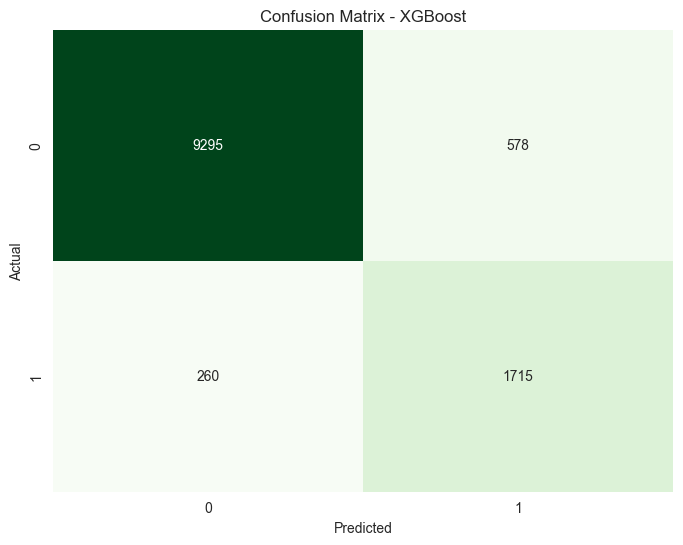


Confusion Matrix:
True Negatives:  9295
False Positives: 578
False Negatives: 260
True Positives:  1715


In [30]:
if XGBOOST_AVAILABLE:
    # Confusion Matrix
    xgb_cm = confusion_matrix(y_test, y_pred_xgb)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title('Confusion Matrix - XGBoost')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print(f'\nConfusion Matrix:')
    print(f'True Negatives:  {xgb_cm[0, 0]}')
    print(f'False Positives: {xgb_cm[0, 1]}')
    print(f'False Negatives: {xgb_cm[1, 0]}')
    print(f'True Positives:  {xgb_cm[1, 1]}')
else:
    print('XGBoost is not available.')


Top 10 Most Important Features (XGBoost):
                    Feature  Importance
        number_transactions    0.374204
Received_currency_UK pounds    0.107776
               num_incoming    0.041395
  Payment_type_Cross-border    0.037606
             total_incoming    0.029426
 Payment_currency_UK pounds    0.023438
                     Amount    0.021657
  Payment_type_Cash Deposit    0.021110
             total_outgoing    0.019207
  Receiver_bank_location_UK    0.013460


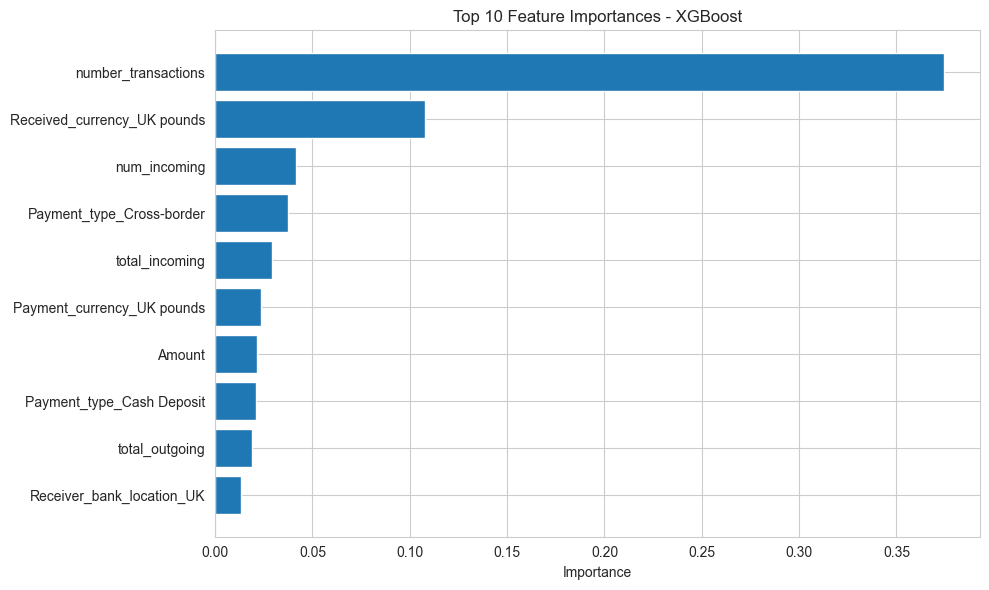

In [31]:
if XGBOOST_AVAILABLE:
    # Feature importance for XGBoost
    xgb_feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print('\nTop 10 Most Important Features (XGBoost):')
    print(xgb_feature_importance.head(10).to_string(index=False))
    
    # Plot top features
    plt.figure(figsize=(10, 6))
    top_features_xgb = xgb_feature_importance.head(10)
    plt.barh(top_features_xgb['Feature'], top_features_xgb['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances - XGBoost')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print('XGBoost is not available.')

## 4. ROC Curves

Plot ROC curves to visualize the trade-off between true positive rate and false positive rate.

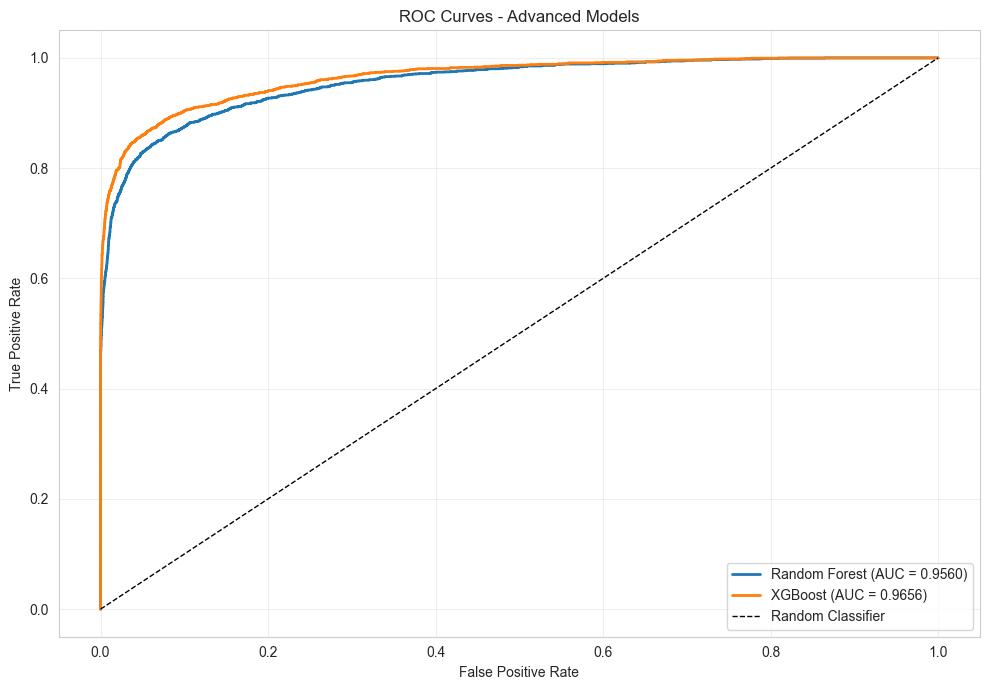

In [32]:
# Calculate ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc_auc:.4f})', linewidth=2)

if XGBOOST_AVAILABLE:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Advanced Models')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Compare Advanced Models

Side-by-side comparison of Random Forest and XGBoost.

In [33]:
# Create comparison dataframe
if XGBOOST_AVAILABLE:
    comparison = pd.DataFrame({
        'Model': ['Random Forest', 'XGBoost'],
        'Accuracy': [rf_accuracy, xgb_accuracy],
        'Precision': [rf_precision, xgb_precision],
        'Recall': [rf_recall, xgb_recall],
        'F1 Score': [rf_f1, xgb_f1],
        'ROC-AUC': [rf_roc_auc, xgb_roc_auc]
    })
else:
    comparison = pd.DataFrame({
        'Model': ['Random Forest'],
        'Accuracy': [rf_accuracy],
        'Precision': [rf_precision],
        'Recall': [rf_recall],
        'F1 Score': [rf_f1],
        'ROC-AUC': [rf_roc_auc]
    })

print('\n' + '=' * 85)
print('ADVANCED MODELS COMPARISON')
print('=' * 85)
print(comparison.to_string(index=False))
print('=' * 85)


ADVANCED MODELS COMPARISON
        Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
Random Forest  0.923953   0.740161 0.837975  0.786037 0.956047
      XGBoost  0.929271   0.747928 0.868354  0.803655 0.965553


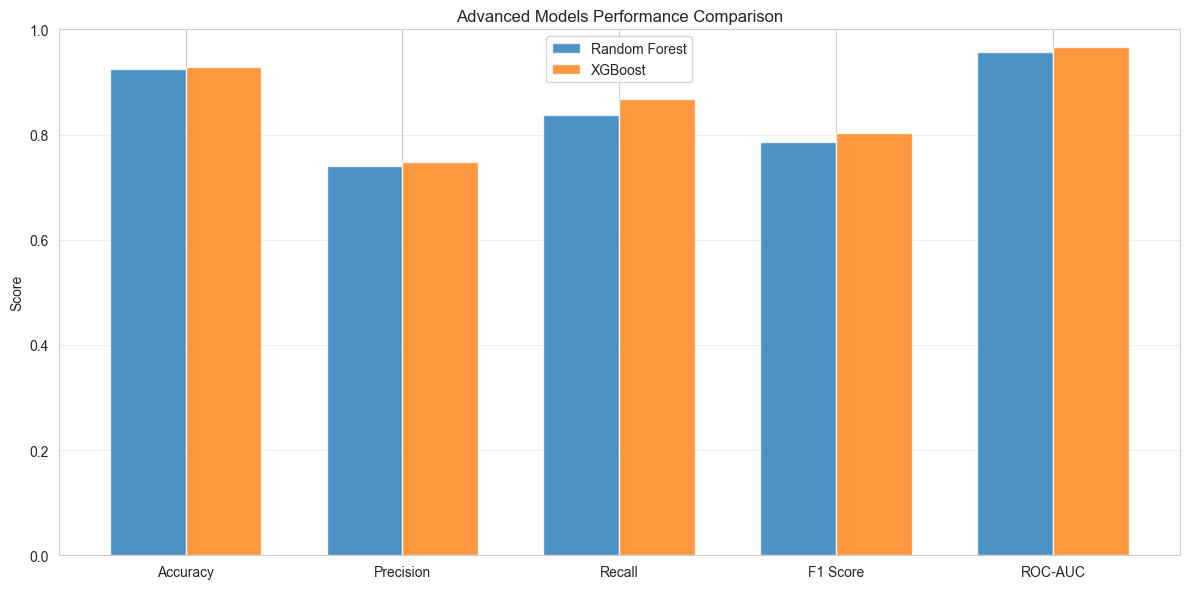

In [34]:
# Visualize comparison
if XGBOOST_AVAILABLE:
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
    rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_roc_auc]
    xgb_scores = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_roc_auc]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, rf_scores, width, label='Random Forest', alpha=0.8)
    ax.bar(x + width/2, xgb_scores, width, label='XGBoost', alpha=0.8)
    
    ax.set_ylabel('Score')
    ax.set_title('Advanced Models Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print('Only Random Forest is available for comparison.')
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
    rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_roc_auc]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(metrics, rf_scores, alpha=0.8, color='steelblue')
    ax.set_ylabel('Score')
    ax.set_title('Random Forest Performance')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Summary

### Advanced Models Performance:

**Random Forest (Memory-Optimized with Subsampling):**
- Ensemble of decision trees with reduced parameters for large datasets
- Uses stratified subsampling (50% of training data) to handle memory constraints
- Uses class weighting to handle imbalance
- `n_estimators=50`, `max_depth=10`, `max_samples=0.8` for memory efficiency
- Provides feature importance rankings
- Generally more robust than single decision trees

**XGBoost** (if available):
- Gradient boosting algorithm - builds trees sequentially
- Often achieves state-of-the-art performance
- Uses `scale_pos_weight` to handle class imbalance
- More computationally intensive but often more accurate

### Key Observations:

1. **ROC-AUC** provides a threshold-independent measure of model performance
2. **Feature importance** helps understand which features drive predictions
3. Both models typically outperform simple baselines (Logistic Regression, Decision Tree)
4. For AML detection, focus on **recall** - catching fraud cases is critical
5. **Memory optimization and subsampling** are crucial for large datasets like this AML dataset

### Next Steps:
- Optimize decision thresholds to improve recall
- Compare all models (baseline + advanced) in one place
- Select the best model for final deployment